# Projeto 1 - Ciência dos Dados

Nome: Amanda Colucci

Nome: Sophia Braz

___
Carregando algumas bibliotecas:

In [82]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import emoji      #biblioteca para a função espaço entre emoji
import operator   #biblioteca para a função espaço entre emoji
import functools  #biblioteca para a função espaço entre emoji
import math


from IPython.display import display
pd.options.display.max_rows = 13

**Em `filename`, coloque o nome do seu arquivo de dados!**

In [83]:
file = 'redbull.xlsx'
if file in os.listdir():
    print(f'Encontramos o arquivo {file}, podemos prosseguir!')
else:
    print(f'Não encontramos o arquivo {file} no diretório {os.getcwd()}!')

Encontramos o arquivo redbull.xlsx, podemos prosseguir!


Carregando a base de dados de treino com os tweets classificados como relevantes, muito relevantes, neutros, irrelevantes e muito irrelevantes:

In [84]:
treinamento = pd.read_excel(file)
treinamento.head(5)

,Tweets Treinamento,relevancia
0,@cauecaralho @jolennu recalque de mandada🥵🥵🥵 e...,0
1,@tubemquerias cala te só mano ahahaha,0
2,quem vai ser a boa alma que vai me trazer um r...,1
3,"rt @airamdinizx: vontade de beber um whisky, c...",2
4,monstrr &gt;&gt; redbull hahahahahahah aqui se...,3


___
## Classificador automático de sentimento


 Descrição do produto escolhido e o que consideramos como relevantes, muito relevantes, neutros, irrelevantes e muito irrelevantes na classificação dos tweets:

 O produto escolhido foi o Redbull, uma bebida energética altamente reconhecida neste meio e vendida mundialmente.
classificamos os tweets em cinco categorias:
* **Muito relevantes**: classificamos os tweets que comparam o produto com os seus concorrentes, como por exemplo "rt @hoppetem: @sonnegar eu acho q redbull tem mt gás... prefiro monster msm, mas a fan base é chata pra krl kkk". 
* **Relevantes**: consideramos aqueles tweets que nos diziam se o cliente gostava ou desgostava do produto, como por exemplo "@mermaiddepp redbull é bom mesmo". 
* **Neutras**: colocamos os tweets que não acrecentavam nada sobre o produto mas que também não eram totalmente irrelevantes, como por exemplo "redbull coco com açaí &gt;&gt;&gt;". 
* **Irrelevantes**: admitimos os tweets que falavam do produto mas não de uma forma que seja de importancia, como por exemplo "rt @diemannschliebe: redbull vc não me ilude mais eu já to acostumada...". 
* **Muito Irrelevantes**: classificamos os tweets que falavam sobre o time de futebol 'Redbull' e frases sem sentido, ou seja, os tweets que usavam somente o nome do produto para representar algo que não acrescentaria nada para nossa análise, como por exemplo "que hd esse hein @canalpremiere no jogo atletico x redbull bragantino?".

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

Definindo as variáveis da planilha treinamento qualitativas como quantitativas:

In [85]:
treinamento['relevancia'] = treinamento['relevancia'].astype('category')
treinamento['relevancia'].cat.categories = ['muito irrelevante', 'irrelevante', 'neutro', 'relevante', 'muito relevante']
treinamento['relevancia'].cat.categories

Index(['muito irrelevante', 'irrelevante', 'neutro', 'relevante',
       'muito relevante'],
      dtype='object')

In [86]:
treinamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Tweets Treinamento  756 non-null    object  
 1   relevancia          756 non-null    category
dtypes: category(1), object(1)
memory usage: 7.0+ KB


In [87]:
contagem_classificacao = treinamento['relevancia'].value_counts()
contagem_classificacao

muito irrelevante    310
neutro               150
irrelevante          118
relevante            105
muito relevante       73
Name: relevancia, dtype: int64

In [88]:
treinamento['Tweets Treinamento'] = treinamento['Tweets Treinamento'].astype('str')

## Fazendo e aplicando funções de limpeza dos tweets (tirando as pontuações e adicionando espaço entre os emojis):


In [89]:
import re 


def cleanup(text):
    """
        Função de limpeza muito simples que troca alguns sinais básicos por espaços
    """
    #import string
    punctuation = '[!-.:?;"\n"()''"",_%$\|/,<>]' # Note que os sinais [] são delimitadores de um conjunto.
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    
    filtro = filter(lambda x:x[0]!='@', text_subbed.split())
    juncao = " ".join(filter(lambda x:x[0]!='@', text_subbed.split()))
    
    return juncao


def espaco_entre_emoji(texto):
    linha = texto.lower()
    linha_separa_emoji = emoji.get_emoji_regexp().split(linha)
    linha_com_espaco = [substr.split() for substr in linha_separa_emoji]
    separa = functools.reduce(operator.concat, linha_com_espaco)
    espaco = ' '.join(separa)
    return espaco


treinamento_separado = treinamento['Tweets Treinamento'].apply(cleanup).apply(espaco_entre_emoji)


Juntando todos os tweets da planilha Treinamento em um texto corrido e separando todas as palavras e as colocando em uma série:

In [90]:
treinamento_string=str()

for i in treinamento_separado:
    treinamento_string+=''+i

todas_palavras=treinamento_string.split()

treinamento_series=pd.Series(todas_palavras)
treinamento_series
#treinamento_series.drop_duplicates().shape

0                  recalque
1                        de
2                   mandada
3                         🥵
4                         🥵
                ...        
13972                   asa
13973                     🕊
13974                     🕊
13975                     🕊
13976    httpstcoqkpcv3ou8c
Length: 13977, dtype: object

**DEFININDO OS EVENTOS:**

 * $MR$: Muito Relevante
 * $R$: Relevante
 * $N$: Neutro
 * $MI$: Muito Irrelevante
 * $I$: Irrelevante

**DEFININDO AS PROBABILIDADES DOS EVENTOS:**

 * $P(MR)$= probabilidade   do   tweet   ser   muito   relevante
 * $P(R)$= probabilidade do tweet ser relevante
 * $P(N)$= probabilidade do tweet ser neutro
 * $P(MI)$= probabilidade do tweet ser muito irrelevante
 * $P(I)$= probabilidade do tweet ser irrelevante


Definindo as probabilidades de ser de cada categoria:

In [91]:
espaco_amostral = treinamento.shape[0]

P_MR = contagem_classificacao['muito relevante']/espaco_amostral
P_R = contagem_classificacao['relevante']/espaco_amostral
P_N = contagem_classificacao['neutro']/espaco_amostral
P_MI = contagem_classificacao['muito irrelevante']/espaco_amostral
P_I = contagem_classificacao['irrelevante']/espaco_amostral

print(f'probabilidade de ser muito relevante: {P_MR}')
print(f'probabilidade de ser relevante: {P_R}')
print(f'probabilidade de ser neutro: {P_N}')
print(f'probabilidade de ser muito irrelevante: {P_MI}')
print(f'probabilidade de ser irrelevante: {P_I}')

probabilidade de ser muito relevante: 0.09656084656084656
probabilidade de ser relevante: 0.1388888888888889
probabilidade de ser neutro: 0.1984126984126984
probabilidade de ser muito irrelevante: 0.41005291005291006
probabilidade de ser irrelevante: 0.15608465608465608


In [92]:
soma_prob = P_MR + P_R +P_N + P_MI + P_I
soma_prob

1.0

Separando os tweets de cada categoria:

In [93]:
relevantes = treinamento[treinamento.relevancia == 'relevante']
muito_relevantes = treinamento[treinamento.relevancia == 'muito relevante']
neutro = treinamento[treinamento.relevancia == 'neutro']
irrelevantes = treinamento[treinamento.relevancia == 'irrelevante']
muito_irrelevantes = treinamento[treinamento.relevancia == 'muito irrelevante']

**"chutando" valores para o smothing:**

In [94]:
#V = numero de palavras desconhecidas que potencialmente existem
#alpha = bonus de cada palavra na contagem
V = 10e4
alpha = 1

## Fazendo o smoothing para todas as categorias:

 * `relevante`:

In [95]:
for i in relevantes['Tweets Treinamento'].head():
    print(i)
    
    
serie_relevantes = []
for i in relevantes['Tweets Treinamento']:
    serie_relevantes += i.split()
frequencia_palavras_relevantes = pd.Series(serie_relevantes).value_counts()
frequencia_palavras_relevantes.head()


monstrr &gt;&gt; redbull hahahahahahah aqui seu otario q gosta de redbull pare imediatamente voce tem q ter um paladar igual ao meu👊🏼👊🏼🤬🤬
olha jovens como eu bebo redbull. nada dessa bebida de plebeu chamada monster rsrsrs. prefiro estragar meus rins com bebida de gente. rsrsrs https://t.co/veb19itfqy
@gatadafelina working on it hhaahaah
redbull é meu pastor e nada me faltará
rt @camilaafonso9: andou a beber redbull para ter aquela energia
@eduzord @xixtoranger é menos enjoativo q redbull

e os sabores sao em maioria gostosos


redbull    97
é          40
de         39
e          33
que        31
dtype: int64

In [96]:
palavras_relevantes = pd.Series(serie_relevantes)

contagem_relevante = palavras_relevantes.value_counts()

total_relevante = contagem_relevante.sum()

cont_relevante_alpha = contagem_relevante + alpha

total_relevante_alpha = total_relevante + (alpha * V)

P_palavra_dado_relevante = cont_relevante_alpha/ total_relevante_alpha


 * `muito relevante`:

In [97]:
for i in muito_relevantes['Tweets Treinamento'].head():
    print(i)
    
    
serie_muito_relevantes = []
for i in muito_relevantes['Tweets Treinamento']:
    serie_muito_relevantes += i.split()
frequencia_palavras_muito_relevantes = pd.Series(serie_muito_relevantes).value_counts()
frequencia_palavras_muito_relevantes.head()


redbull é melhor
redbull é melhor que monster
@sonnegar eu acho q redbull tem mt gás... prefiro monster msm, mas a fan base é chata pra krl kkkkkk
redbull de açaí é o melhor energético
rt @pqplorrankkk: redbull é melhor que monster! #ad


redbull    68
é          45
de         30
eu         22
que        21
dtype: int64

In [98]:
palavras_muito_relevantes = pd.Series(serie_muito_relevantes)

contagem_muito_relevante = palavras_muito_relevantes.value_counts()

total_muito_relevante = contagem_muito_relevante.sum()

cont_muito_relevante_alpha = contagem_muito_relevante + alpha

total_muito_relevante_alpha = total_muito_relevante + (alpha * V)

P_palavra_dado_muito_relevante = cont_muito_relevante_alpha/ total_muito_relevante_alpha

 * `neutro`:

In [99]:
for i in neutro['Tweets Treinamento'].head():
    print(i)
    
    
serie_neutro = []
for i in neutro['Tweets Treinamento']:
    serie_neutro += i.split()
frequencia_palavras_neutro = pd.Series(serie_neutro).value_counts()
frequencia_palavras_neutro.head()


rt @airamdinizx: vontade de beber um whisky, c gelo de coco e um redbull bem gelado pqp
mais uma segunda chegando ao fim
hoje ganhei massagens das porrada que a vida dá
pofavô divertidamente da ansiedade me ajuda a dormir antes da meia noite
eu preciso acorda bem amanhã e pegar estrada
já preparei as mala e o redbull tá pra gela
a vida é curta e eu sou grossa
mds preciso muito dessa camisa azul do santos, preciso mais do que uma da redbull
@kaioshxn hj to bebendo redbull (com gin), mas já tentei tnt, monster, etc kkkkkk
vou evitar beber muito redbull hoje


redbull    136
e           92
de          75
o           62
eu          48
dtype: int64

In [100]:
palavras_neutro = pd.Series(serie_neutro)

contagem_neutro = palavras_neutro.value_counts()

total_neutro = contagem_neutro.sum()

cont_neutro_alpha = contagem_neutro + alpha

total_neutro_alpha = total_neutro + (alpha * V)

P_palavra_dado_neutro = cont_neutro_alpha/ total_neutro_alpha

 * `irrelevante`:

In [101]:
for i in irrelevantes['Tweets Treinamento'].head():
    print(i)
    
    
serie_irrelevantes = []
for i in irrelevantes['Tweets Treinamento']:
    serie_irrelevantes += i.split()
frequencia_palavras_irrelevantes = pd.Series(serie_irrelevantes).value_counts()
frequencia_palavras_irrelevantes.head()


quem vai ser a boa alma que vai me trazer um redbull aqui no trampo heinn??!
cartolouco tem redbull introduzido na veia kkk
mlq redbull é uma praga, durmo por nada
redbull pode ate te da asas, mas sou eu quem vou te dar amor e carinho, nenem
teve uma vez que eu tomei redbull fui p cinema e dormi o filme inteiro???


redbull    103
de          63
que         60
e           52
o           42
dtype: int64

In [102]:
palavras_irrelevantes = pd.Series(serie_irrelevantes)

contagem_irrelevante = palavras_irrelevantes.value_counts()

total_irrelevante = contagem_irrelevante.sum()

cont_irrelevante_alpha = contagem_irrelevante + alpha

total_irrelevante_alpha = total_irrelevante + (alpha * V)

P_palavra_dado_irrelevante = cont_irrelevante_alpha/ total_irrelevante_alpha

 * `muito irrelevante`:

In [103]:
for i in muito_irrelevantes['Tweets Treinamento'].head():
    print(i)
    
    
serie_muito_irrelevantes = []
for i in muito_irrelevantes['Tweets Treinamento']:
    serie_muito_irrelevantes += i.split()
frequencia_palavras_muito_irrelevantes = pd.Series(serie_muito_irrelevantes).value_counts()
frequencia_palavras_muito_irrelevantes.head()

@cauecaralho @jolennu recalque de mandada🥵🥵🥵 eu tiro debochando 🤪🤪 aceita que eu sou foda 😎😎😎 e late que eu tô passando 🐕🗣🗣🐕 quem da moral pra merda é mosca 💩🦟🦟🦟 rala sua mandada 👺👺👺 nem redbull faz piranha 🐟🐟🐟 criar asa 🕊🕊🕊
@tubemquerias cala te só mano ahahaha
se o albon quiser ficar na redbull que consiga esse pódio. só depende dele. #f1naglobo
@mortais_4 quer dizer, c n prefere redbull?*
@sillva1eduardo @helenarosa181 @lazarini_denis @caparica se a redbull tivesse as mesmas condições da mercedes 
até o leclerc eu coloco uma esperança, mas com essa ferrari aí fica tenso


eu         201
que        200
redbull    196
e          150
de         150
dtype: int64

In [104]:
palavras_muito_irrelevantes = pd.Series(serie_muito_irrelevantes)

contagem_muito_irrelevante = palavras_muito_irrelevantes.value_counts()

total_muito_irrelevante = contagem_muito_irrelevante.sum()

cont_muito_irrelevante_alpha = contagem_muito_irrelevante + alpha

total_muito_irrelevante_alpha = total_muito_irrelevante + (alpha * V)

P_palavra_dado_muito_irrelevante = cont_muito_irrelevante_alpha/ total_muito_irrelevante_alpha

## Classificador - montagem e aplicação na planilha Treinamento:

In [105]:
dicionario = {}
classificador = []

for i in range(len(treinamento)):
    tweet = treinamento.iloc[i,0]
    palavras_tweet = tweet.split()
    
    prob_tweet_relevante = 1
    prob_tweet_muito_relevante=1
    prob_tweet_neutro = 1
    prob_tweet_irrelevante = 1
    prob_tweet_muito_irrelevante =1
    
    for palavra in palavras_tweet:

        if palavra in serie_relevantes:
            prob_palavra_relevante = P_palavra_dado_relevante[palavra] 
            prob_tweet_relevante *= prob_palavra_relevante
        
        else:
            prob_palavra_relevante = (alpha/total_relevante_alpha)
            prob_tweet_relevante *= prob_palavra_relevante    
            
            
        if palavra in serie_muito_relevantes:
            prob_palavra_muito_relevante = P_palavra_dado_muito_relevante[palavra] 
            prob_tweet_muito_relevante *= prob_palavra_muito_relevante
            
        else:
            prob_palavra_muito_relevante = (alpha/total_muito_relevante_alpha)
            prob_tweet_muito_relevante *= prob_palavra_muito_relevante
            
        
        if palavra in serie_neutro:
            prob_palavra_neutra = P_palavra_dado_neutro[palavra] 
            prob_tweet_neutro *= prob_palavra_neutra
            
        else:
            prob_palavra_neutra = (alpha/total_neutro_alpha)
            prob_tweet_neutro *= prob_palavra_neutra
            
        
        if palavra in serie_irrelevantes:
            prob_palavra_irrelevante = (alpha/total_irrelevante_alpha)
            prob_tweet_irrelevante *= prob_palavra_irrelevante 
            
        else:
            prob_palavra_irrelevante = (alpha/total_irrelevante_alpha)
            prob_tweet_irrelevante *= prob_palavra_irrelevante
        

        if palavra in serie_muito_irrelevantes:
            prob_palavra_muito_irrelevante = (alpha/total_muito_irrelevante_alpha)
            prob_tweet_muito_irrelevante *= prob_palavra_muito_irrelevante  
            
        else:
            prob_palavra_muito_irrelevante = (alpha/total_muito_irrelevante_alpha)
            prob_tweet_muito_irrelevante *= prob_palavra_muito_irrelevante
        

    # cálculo com as prioris
    prob_tweet_relevante *= P_R
    prob_tweet_muito_relevante *= P_MR
    prob_tweet_neutro *= P_N
    prob_tweet_irrelevante *= P_I
    prob_tweet_muito_irrelevante *= P_MI
    
    if prob_tweet_relevante > prob_tweet_muito_relevante and prob_tweet_relevante >prob_tweet_neutro and prob_tweet_relevante>prob_tweet_irrelevante and prob_tweet_relevante>prob_tweet_muito_irrelevante:
        classificador = "relevante"

    if prob_tweet_muito_relevante > prob_tweet_relevante and prob_tweet_muito_relevante >prob_tweet_neutro and prob_tweet_muito_relevante>prob_tweet_irrelevante and prob_tweet_muito_relevante>prob_tweet_muito_irrelevante:
        classificador = "muito relevante"

    if prob_tweet_neutro > prob_tweet_relevante and prob_tweet_neutro >prob_tweet_muito_relevante and prob_tweet_neutro >prob_tweet_irrelevante and prob_tweet_neutro >prob_tweet_muito_irrelevante:
        classificador = "neutro"

    if prob_tweet_irrelevante > prob_tweet_muito_relevante and prob_tweet_irrelevante >prob_tweet_neutro and prob_tweet_irrelevante >prob_tweet_relevante and prob_tweet_irrelevante >prob_tweet_muito_irrelevante:
        classificador = "irrelevante"

    if prob_tweet_muito_irrelevante > prob_tweet_relevante and prob_tweet_muito_irrelevante >prob_tweet_neutro and prob_tweet_muito_irrelevante >prob_tweet_irrelevante and prob_tweet_muito_irrelevante >prob_tweet_muito_relevante:
        classificador = "muito irrelevante"

    
    dicionario[tweet] = (prob_tweet_relevante, prob_tweet_muito_relevante, prob_tweet_neutro, prob_tweet_irrelevante, prob_tweet_muito_irrelevante, classificador)
    


data_frame = pd.DataFrame.from_dict(data = dicionario, orient='index').reset_index()
data_frame.columns = ["Tweets", "Prob de ser relevante", "Prob de ser muito relevante", "Prob de ser neutro", "Prob de ser irrelevante", "Prob de ser muito irrelevante", "classificador"]
data_frame.head(10)



,Tweets,Prob de ser relevante,Prob de ser muito relevante,Prob de ser neutro,Prob de ser irrelevante,Prob de ser muito irrelevante,classificador
0,@cauecaralho @jolennu recalque de mandada🥵🥵🥵 e...,1.650663e-193,3.733275e-195,1.274288e-188,6.571640e-212,2.176126e-212,neutro
1,@tubemquerias cala te só mano ahahaha,1.150231e-29,1.281936e-30,1.537384e-29,1.379402e-31,2.695720e-31,neutro
2,quem vai ser a boa alma que vai me trazer um r...,8.546282e-71,5.699671e-75,6.520228e-68,1.122643e-81,1.339881e-81,neutro
3,"rt @airamdinizx: vontade de beber um whisky, c...",8.805536e-74,1.224328e-76,2.024759e-68,1.099757e-86,1.249411e-86,neutro
4,monstrr &gt;&gt; redbull hahahahahahah aqui se...,3.222502e-96,3.153016e-102,1.999253e-98,9.921380e-112,8.808482e-112,relevante
5,mais uma segunda chegando ao fim\nhoje ganhei ...,5.935946e-237,3.257942e-243,8.822270e-219,5.239377e-267,1.008590e-267,neutro
6,"mds preciso muito dessa camisa azul do santos,...",1.162289e-66,6.099469e-69,1.138925e-61,1.146005e-76,1.436902e-76,neutro
7,se o albon quiser ficar na redbull que consiga...,1.200370e-67,8.086417e-70,8.183642e-66,1.146005e-76,1.436902e-76,neutro
8,cartolouco tem redbull introduzido na veia kkk,5.780876e-32,2.504975e-33,3.012980e-32,1.351281e-36,2.513703e-36,relevante
9,"mlq redbull é uma praga, durmo por nada",1.818077e-35,1.370562e-36,1.111147e-34,1.323734e-41,2.343975e-41,neutro


In [106]:
verificacao = pd.crosstab(treinamento['relevancia'], data_frame['classificador'])
verificacao

classificador,muito irrelevante,muito relevante,neutro,relevante
relevancia,,,,
muito irrelevante,5,0,301,4
irrelevante,1,0,112,5
neutro,0,0,150,0
relevante,0,1,42,62
muito relevante,0,36,34,3


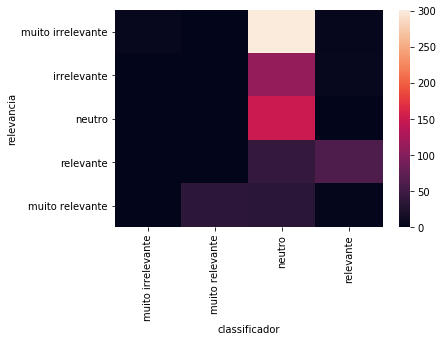

In [107]:
import seaborn as sns 
sns.heatmap(verificacao)

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

**Preparando a planilha Teste:**

In [108]:
teste = pd.read_excel(file, sheet_name = 'Teste')
teste['Tweets Teste'] = teste['Tweets Teste'].astype('str')
teste['Tweets Teste'] = teste['Tweets Teste'].apply(cleanup).apply(espaco_entre_emoji)
teste['Tweets Teste'] = teste['Tweets Teste'].str.lower()

In [109]:
teste['relevancia'].value_counts()

0    210
2     90
3     88
1     84
4     30
Name: relevancia, dtype: int64

In [110]:
teste['relevancia'] = teste['relevancia'].astype('category')
teste['relevancia'].cat.categories = ['muito irrelevante', 'irrelevante', 'neutro', 'relevante', 'muito relevante']
teste['relevancia'].cat.as_ordered()

0                 neutro
1                 neutro
2            irrelevante
3      muito irrelevante
4            irrelevante
             ...        
497            relevante
498    muito irrelevante
499               neutro
500            relevante
501          irrelevante
Name: relevancia, Length: 502, dtype: category
Categories (5, object): [muito irrelevante < irrelevante < neutro < relevante < muito relevante]

## Aplicando o classificador na planilha Teste:

In [111]:
dicionario = {}
classificador = []

for i in range(len(teste)):
    tweet = teste.iloc[i,0]
    palavras_tweet = tweet.split()
    
    prob_tweet_relevante = 1
    prob_tweet_muito_relevante=1
    prob_tweet_neutro = 1
    prob_tweet_irrelevante = 1
    prob_tweet_muito_irrelevante =1
    
    for palavra in palavras_tweet:

        if palavra in serie_relevantes:
            prob_palavra_relevante = P_palavra_dado_relevante[palavra] 
            prob_tweet_relevante *= prob_palavra_relevante
        
        else:
            prob_palavra_relevante = (alpha/total_relevante_alpha)
            prob_tweet_relevante *= prob_palavra_relevante    
            
            
        if palavra in serie_muito_relevantes:
            prob_palavra_muito_relevante = P_palavra_dado_muito_relevante[palavra] 
            prob_tweet_muito_relevante *= prob_palavra_muito_relevante
            
        else:
            prob_palavra_muito_relevante = (alpha/total_muito_relevante_alpha)
            prob_tweet_muito_relevante *= prob_palavra_muito_relevante
            
        
        if palavra in serie_neutro:
            prob_palavra_neutra = P_palavra_dado_neutro[palavra] 
            prob_tweet_neutro *= prob_palavra_neutra
            
        else:
            prob_palavra_neutra = (alpha/total_neutro_alpha)
            prob_tweet_neutro *= prob_palavra_neutra
            
        
        if palavra in serie_irrelevantes:
            prob_palavra_irrelevante = (alpha/total_irrelevante_alpha)
            prob_tweet_irrelevante *= prob_palavra_irrelevante 
            
        else:
            prob_palavra_irrelevante = (alpha/total_irrelevante_alpha)
            prob_tweet_irrelevante *= prob_palavra_irrelevante
        

        if palavra in serie_muito_irrelevantes:
            prob_palavra_muito_irrelevante = (alpha/total_muito_irrelevante_alpha)
            prob_tweet_muito_irrelevante *= prob_palavra_muito_irrelevante  
            
        else:
            prob_palavra_muito_irrelevante = (alpha/total_muito_irrelevante_alpha)
            prob_tweet_muito_irrelevante *= prob_palavra_muito_irrelevante
        

    # cálculo com as prioris
    prob_tweet_relevante *= P_R
    prob_tweet_muito_relevante *= P_MR
    prob_tweet_neutro *= P_N
    prob_tweet_irrelevante *= P_I
    prob_tweet_muito_irrelevante *= P_MI
    
    if prob_tweet_relevante > prob_tweet_muito_relevante and prob_tweet_relevante >prob_tweet_neutro and prob_tweet_relevante>prob_tweet_irrelevante and prob_tweet_relevante>prob_tweet_muito_irrelevante:
        classificador = "relevante"

    if prob_tweet_muito_relevante > prob_tweet_relevante and prob_tweet_muito_relevante >prob_tweet_neutro and prob_tweet_muito_relevante>prob_tweet_irrelevante and prob_tweet_muito_relevante>prob_tweet_muito_irrelevante:
        classificador = "muito relevante"

    if prob_tweet_neutro > prob_tweet_relevante and prob_tweet_neutro >prob_tweet_muito_relevante and prob_tweet_neutro >prob_tweet_irrelevante and prob_tweet_neutro >prob_tweet_muito_irrelevante:
        classificador = "neutro"

    if prob_tweet_irrelevante > prob_tweet_muito_relevante and prob_tweet_irrelevante >prob_tweet_neutro and prob_tweet_irrelevante >prob_tweet_relevante and prob_tweet_irrelevante >prob_tweet_muito_irrelevante:
        classificador = "irrelevante"

    if prob_tweet_muito_irrelevante > prob_tweet_relevante and prob_tweet_muito_irrelevante >prob_tweet_neutro and prob_tweet_muito_irrelevante >prob_tweet_irrelevante and prob_tweet_muito_irrelevante >prob_tweet_muito_relevante:
        classificador = "muito irrelevante"

    
    dicionario[tweet] = (prob_tweet_relevante, prob_tweet_muito_relevante, prob_tweet_neutro, prob_tweet_irrelevante, prob_tweet_muito_irrelevante, classificador)
    


data_frame_teste = pd.DataFrame.from_dict(data = dicionario, orient='index').reset_index()
data_frame_teste.columns = ["Tweets", "Prob de ser relevante", "Prob de ser muito relevante", "Prob de ser neutro", "Prob de ser irrelevante", "Prob de ser muito irrelevante", "classificador"]
data_frame_teste.head(10)


,Tweets,Prob de ser relevante,Prob de ser muito relevante,Prob de ser neutro,Prob de ser irrelevante,Prob de ser muito irrelevante,classificador
0,a heloa compro tanto redbull pra leva pra prai...,1.221278e-83,2.585063e-87,5.929365e-80,1.055375e-96,1.086385e-96,neutro
1,tem lugar que vende monster a preço de redbull 😔,1.044237e-42,8.734050e-44,1.394413e-41,1.270314e-51,2.038127e-51,neutro
2,você não falou ontem que iria se ausentarapare...,1.888645e-62,2.719435e-64,1.017023e-60,1.169853e-71,1.540948e-71,neutro
3,⚽ para amar ou odiar aqui tem uma lista com im...,3.733099e-160,5.647960e-164,1.315942e-155,7.590811e-177,3.549850e-177,neutro
4,tomei um anador só falta um redbull 😎,2.292209e-34,2.980724e-36,9.142753e-34,1.323734e-41,2.343975e-41,neutro
5,parabéns maya uma história de superação vc é u...,7.715047e-60,3.534626e-61,5.148677e-58,1.194198e-66,1.652528e-66,neutro
6,redbull é bom mesmo,4.223613e-17,9.466353e-17,4.575620e-17,1.437410e-21,3.100248e-21,muito relevante
7,são paulo só depende dele pra assumir a lidera...,7.276819e-103,2.483472e-104,1.510120e-100,9.921380e-112,8.808482e-112,neutro
8,eu até que gostava de monster mas depois de ví...,1.575417e-210,2.674352e-211,2.647311e-203,5.807701e-242,1.430602e-242,neutro
9,n consegui dormir a noite toda e ainda vou pra...,1.204011e-62,5.339982e-65,2.276896e-59,1.169853e-71,1.540948e-71,neutro


In [112]:
verificando_teste = pd.crosstab(teste['relevancia'], data_frame_teste['classificador'])
verificando_teste

classificador,muito irrelevante,muito relevante,neutro,relevante
relevancia,,,,
muito irrelevante,2,2,203,2
irrelevante,1,2,77,3
neutro,0,0,86,3
relevante,0,3,82,2
muito relevante,0,2,28,0


In [113]:
verificando_2 = pd.crosstab(teste['relevancia'], data_frame_teste['classificador'], normalize='all')
verificando_2

classificador,muito irrelevante,muito relevante,neutro,relevante
relevancia,,,,
muito irrelevante,0.004016,0.004016,0.407631,0.004016
irrelevante,0.002008,0.004016,0.154618,0.006024
neutro,0.000000,0.000000,0.172691,0.006024
relevante,0.000000,0.006024,0.164659,0.004016
muito relevante,0.000000,0.004016,0.056225,0.000000


## Cálculo da qualidade do classificador por categoria:


 * `Categoria relevante`:

In [114]:
print(f'porcentagem de verdadeiros positivos: {(verificando_2.iloc[3,3])*100:.5g}%')
print(f'porcentagem de falsos positivos: {(verificando_2.iloc[3,0]+verificando_2.iloc[3,1]+verificando_2.iloc[3,2])*100:.5g}%')

porcentagem de verdadeiros positivos: 0.40161%
porcentagem de falsos positivos: 17.068%


 * `Categoria muito relevante`:

In [115]:
print(f'porcentagem de verdadeiros positivos: {(verificando_2.iloc[4,1])*100:.5g}%')
print(f'porcentagem de falsos positivos: {(verificando_2.iloc[4,0]+verificando_2.iloc[4,2]+verificando_2.iloc[4,3])*100:.5g}%')

porcentagem de verdadeiros positivos: 0.40161%
porcentagem de falsos positivos: 5.6225%


* `Categoria neutro`:

In [116]:
print(f'porcentagem de verdadeiros positivos: {(verificando_2.iloc[2,2])*100:.5g}%')
print(f'porcentagem de falsos positivos: {(verificando_2.iloc[2,0]+verificando_2.iloc[2,1]+verificando_2.iloc[2,3])*100:.5g}%')

porcentagem de verdadeiros positivos: 17.269%
porcentagem de falsos positivos: 0.60241%


 * `Categoria irrelevante`:

In [117]:
print(f'porcentagem de verdadeiros positivos: {(0)*100:.5g}%')
print(f'porcentagem de falsos positivos: {(verificando_2.iloc[1,0]+verificando_2.iloc[1,1]+verificando_2.iloc[1,2]+verificando_2.iloc[1,3])*100:.5g}%')

porcentagem de verdadeiros positivos: 0%
porcentagem de falsos positivos: 16.667%


 * `Categoria muito irrelevante`:

In [118]:
print(f'porcentagem de verdadeiros positivos: {(verificando_2.iloc[0,0])*100:.5g}%')
print(f'porcentagem de falsos positivos: {(verificando_2.iloc[0,1]+verificando_2.iloc[0,2]+verificando_2.iloc[0,3])*100:.5g}%')

porcentagem de verdadeiros positivos: 0.40161%
porcentagem de falsos positivos: 41.566%


___
### Concluindo

**Cálculo da acurácia do classificador:**


In [119]:
#verificando_2.iloc[1,], que seria o irrelevante não esta aparecendo na nossa tabela, representamos ele no 
#cálculo da verificação como o zero no final
print(f'a acurácia do classificador é de: {(verificando_2.iloc[0,0]+verificando_2.iloc[2,2]+verificando_2.iloc[3,3]+verificando_2.iloc[4,1]+0)*100:.5g}%')

a acurácia do classificador é de: 18.474%


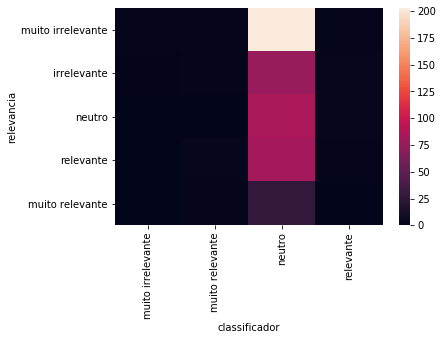

In [120]:
sns.heatmap(verificando_teste)

##### Explicação (aperfeiçoamento):

A acurácia do nosso classificador é de aproximadamente 20%, o que não é esperado, porém acreditamos que com uma base de dados melhor e mais ampla, isso mudaria.
As mensagens de dupla negação e sarcasmo, foram separadas na parte de classificação manual do teste, na sua devida categoria, levando em consideração o sarcasmo. Se for utilizado o mesmo tipo de fase sarcastica em outro tweet, o classificador, aumentará a probabilidade deste tweet ser da determinada categoria que a sinalizamos no excel. Portanto, isso pode acabar nos prejudicando em certos casos, ou nos ajudando, depende muito se é uma frase sarcastica mais "comum", ou não, sendo que neste caso, a probabilidade tenderá a outra categoria. Porém caso este projeto tenha uma base de dados melhor e mais balanciada, não tendendo mais a uma categoria específica, isso deixaria nosso classificador muito melhor e faria com que fosse um ótimo classificador, já que existem muitos tweets irrelevantes sobre o produto 'redbull' e ao filtar os relevantes, isso ajudaria a perceber as suas melhores características e as piores, assim com essa informação, seria muito mais facil de perceber o que os clientes querem que fique ou que mude do produto em si.  

Fora do contexto do Projeto, o Naive Bayes poderia ser usado na área de finanças, especialmente na detecção fraudes, ou seja, ele seria capaz de identificar se uma transação financeira é “duvidosa” ou “legal”. Além disso ele poderia ser usado também para classificar um cliente específico como sendo de “alto”, “médio” ou “baixo” risco para se conceber um crédito bancário. 

Para uma melhor acurácia do classificador poderiamos ter levado em conta outros tipos de limpeza dos dados, como por exemplo verificar a ortografia dos tweets.

Não podemos usar nosso classificador para gerar mais amostras de treinamento, pois como ele não está 100% correto, as amostras em sua maioria poderiam sair erradas, podendo haver informações equivocadas que atrapalhariam ainda mais a acurácia do classificador. 

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* Montar um dashboard que realiza análise de sentimento e visualiza estes dados

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

para a função cleanup usamos o código referente a esse site, porém mudamos os nomes das variáveis presentes nele: https://stackoverflow.com/questions/49921720/how-to-split-emoji-from-each-other-python